In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.interpolate import CubicSpline
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [9, 9]
mpl.rcParams['font.size'] = 27

mpl.rcParams['savefig.dpi'] = 150 
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10 
mpl.rcParams['xtick.minor.size'] = 5 

mpl.rcParams['ytick.major.size'] = 10 
mpl.rcParams['ytick.minor.size'] = 5 

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23

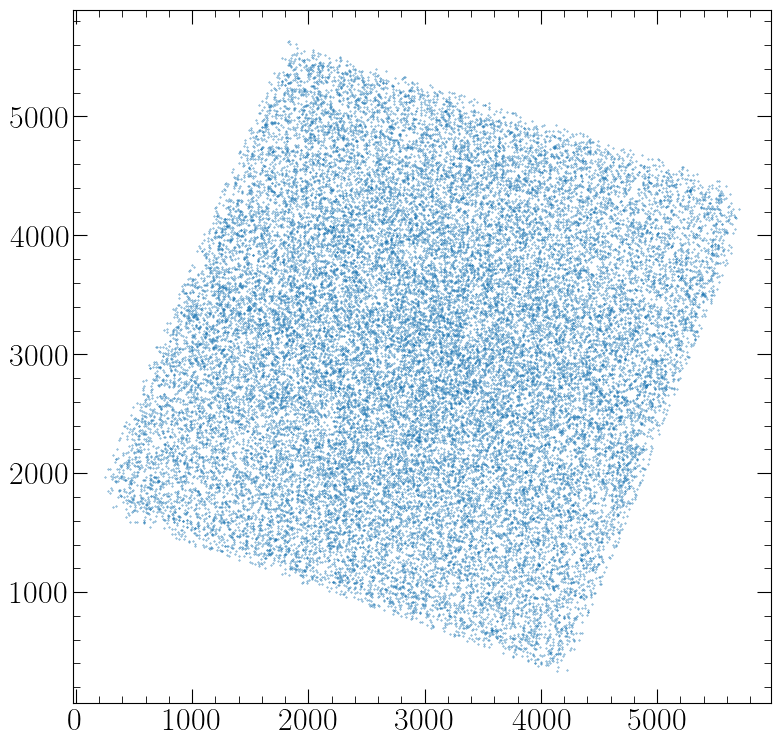

In [3]:
GC_name = 'NGC6362'
path = os.getcwd()
df = pd.read_csv("{}/{}.dat".format(path,GC_name),sep='\s+')
plt.scatter(df['x'],df['y'],s=0.1);

In [4]:
#determin center
x_guess,y_guess = 3000,3000
radius = 200
def centeroidnp(df):
    fit_stars = df[((df['x']-x_guess)**2 + (df['y']-y_guess)**2) < radius**2]
    length = len(fit_stars)
    x = fit_stars['x'].values
    y = fit_stars['y'].values
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    return sum_x/length, sum_y/length
x_cen, y_cen = centeroidnp(df)
print("X Center is: {}".format(x_cen))
print("Y Center is: {}".format(y_cen))

X Center is: 2994.711802292263
Y Center is: 3004.8085042979947


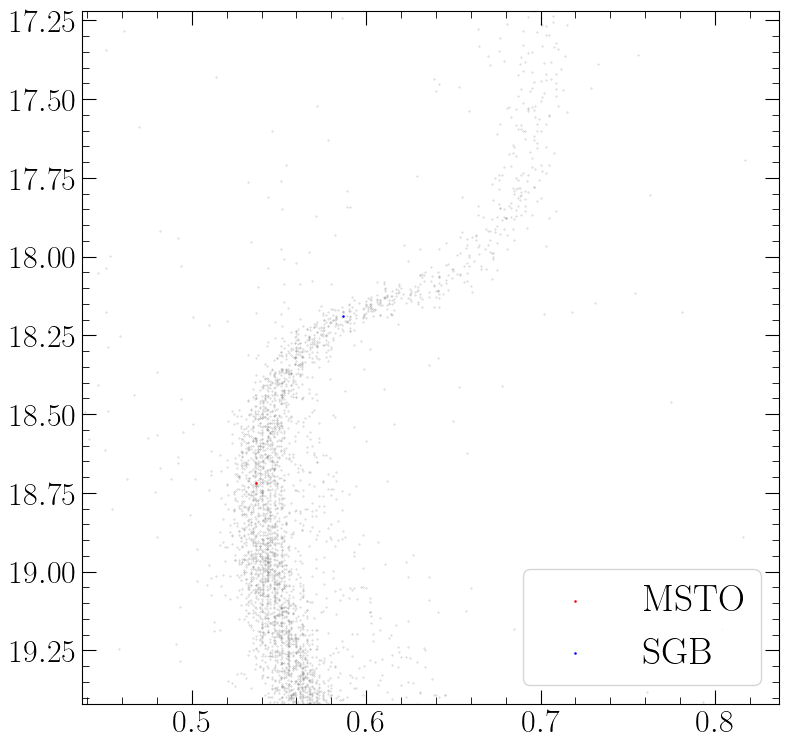

In [11]:
#determine MSTO and SGB
plt.scatter(df['VIvega'],df['Vvega'],s=0.1,alpha=0.5,c='grey')
V_MSTO = 18.72
VI_MSTO = 0.537
plt.scatter(VI_MSTO,V_MSTO,s=0.7,c='r',label='MSTO')
V_SGB = 18.19
VI_SGB = VI_MSTO + 0.05
plt.scatter(VI_SGB,V_SGB,s=0.7,c='b',label='SGB')
plt.xlim(VI_MSTO -0.1,VI_MSTO + 0.3)
plt.ylim(V_MSTO - 1.5,V_MSTO + 0.7)
plt.legend()
plt.gca().invert_yaxis()

$$\textup{V}_{\textup{MSTO}} = 18.72$$
$$\textup{VI}_{\textup{MSTO}} = 0.537$$
$$\textup{V}_{\textup{SGB}} = 18.19$$
$$\textup{VI}_{\textup{SGB}} = 0.587$$

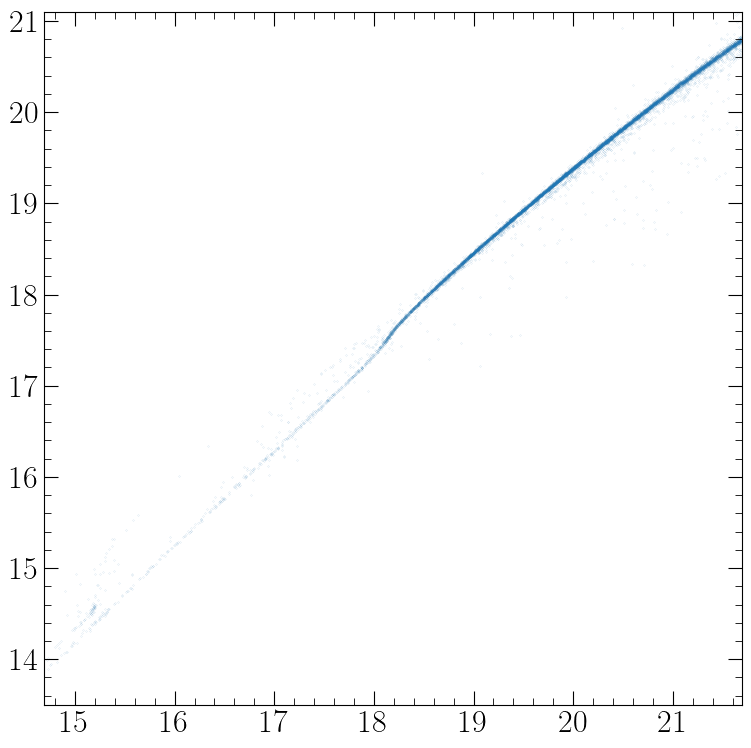

In [16]:
#plot the v vs i image within 3.5 mag from sgb
V_min = V_SGB - 3.5
V_max = V_SGB + 3.5
df_first_cut = df[(df['Vvega'] < V_max) & (df['Vvega'] > V_min)]
plt.scatter(df_first_cut['Vvega'],df_first_cut['Ivega'],s=0.003)
plt.xlim(V_min, V_max)
plt.ylim(13.5,21.1)
# plt.savefig("{}/vi.png".format(path),dpi=500);

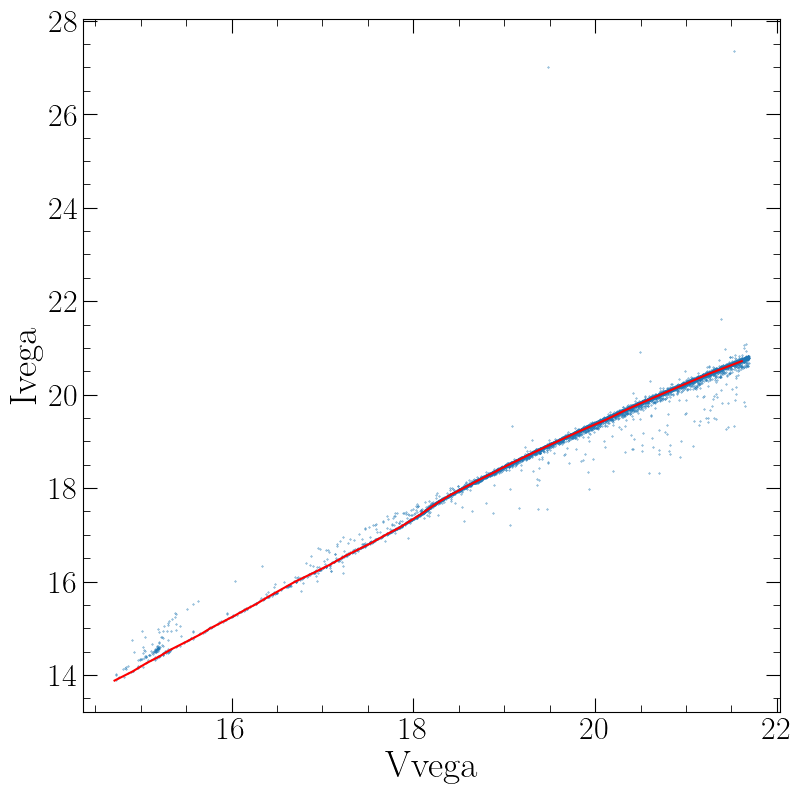

In [17]:
#Selected ridgeline points
ridgeline = pd.read_csv("{}/{}_ridgeline_points.csv".format(path,GC_name),names=['Vvega','Ivega'])
df_first_cut = df[(df['Vvega'] < V_max) & (df['Vvega'] > V_min)]
vp = ridgeline['Vvega'].values
ip = ridgeline['Ivega'].values
plt.scatter(df_first_cut['Vvega'],df_first_cut['Ivega'],s=0.1)
plt.xlabel('Vvega')
plt.ylabel('Ivega')
plt.plot(vp,ip,c='r');

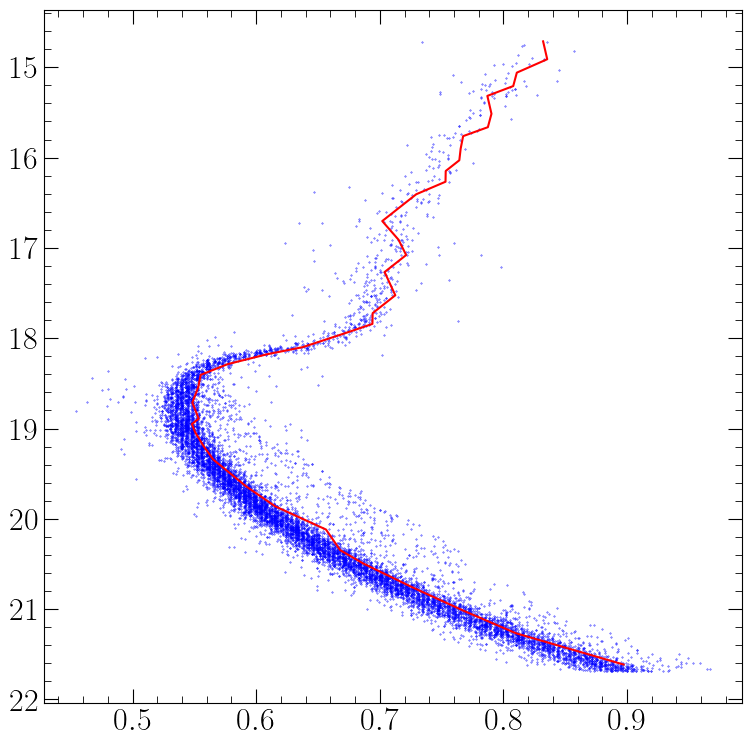

In [19]:
Vvega = df_first_cut['Vvega'].values
Ivega = df_first_cut['Ivega'].values
VIvega = df_first_cut['VIvega'].values
d = []
mag_cut = 0.1
for i in range(len(Ivega)):
    x = Ivega[i]
    y = Vvega[i]
    Vvega_needed = np.interp(x,ip,vp) #new linear interpolation
    Ivega_needed = np.interp(y,vp,ip)
    #use slightly bigger cut to avoid deleting too much points. A finer cut will be applied once the fiducial cmd is generated
    if (((Vvega_needed + mag_cut) > Vvega[i]) & (Vvega[i] > (Vvega_needed - mag_cut))) & (((Ivega_needed + mag_cut) > Ivega[i]) & (Ivega[i] > (Ivega_needed - mag_cut))):
        d.append(df_first_cut.iloc[i][['Vvega','err','Ivega','err.2','VIvega','err.1','x','y']].values.tolist())
df_second_cut = pd.DataFrame(d,columns=['v','v_err','i','i_err','vi','vi_err','x','y'])
plt.scatter(df_second_cut['vi'],df_second_cut['v'],s=0.1,c='b')
plt.plot(vp-ip,vp,c='r')
plt.gca().invert_yaxis();

In [20]:
df_second_cut.to_csv("{}/{}_fitstars_cmd.dat".format(path,GC_name),sep=',',index=False)

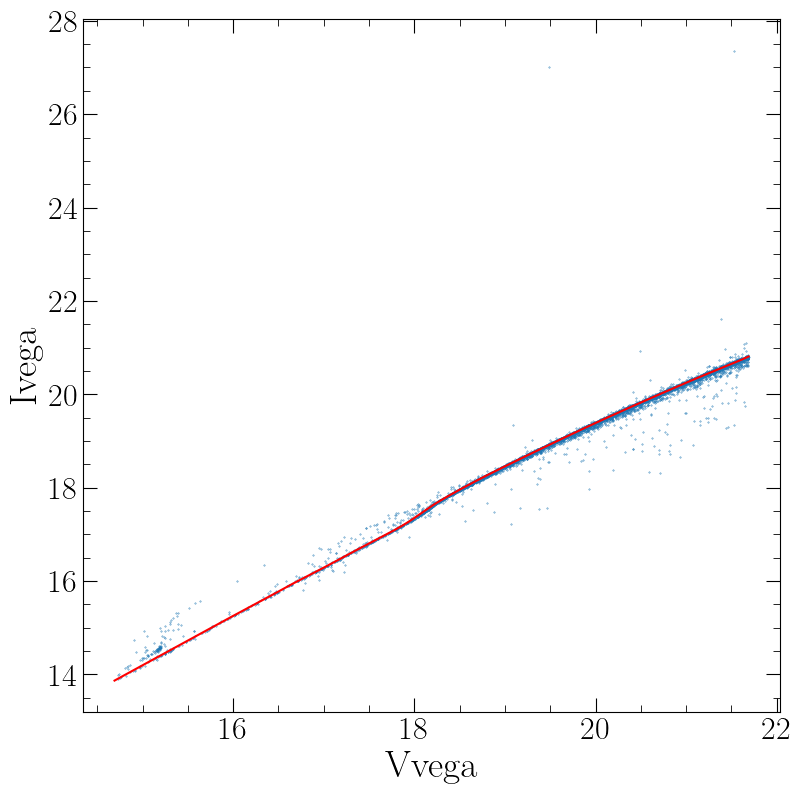

In [21]:
ridgeline = pd.read_csv("{}/fiducial_lines.csv".format(path))
#plot the v vs i image within 3.5 mag from sgb
V_min = V_SGB - 3.5
V_max = V_SGB + 3.5
df_first_cut = df[(df['Vvega'] < V_max) & (df['Vvega'] > V_min)]
vp = ridgeline['v'].values
ip = ridgeline['v'].values - ridgeline['vi'].values
if vp[0] > vp[-1]:
    vp = np.flip(vp)
if ip[0] > ip[-1]:
    ip = np.flip(ip)
plt.scatter(df_first_cut['Vvega'],df_first_cut['Ivega'],s=0.1)
plt.xlabel('Vvega')
plt.ylabel('Ivega')
plt.plot(vp,ip,c='r')

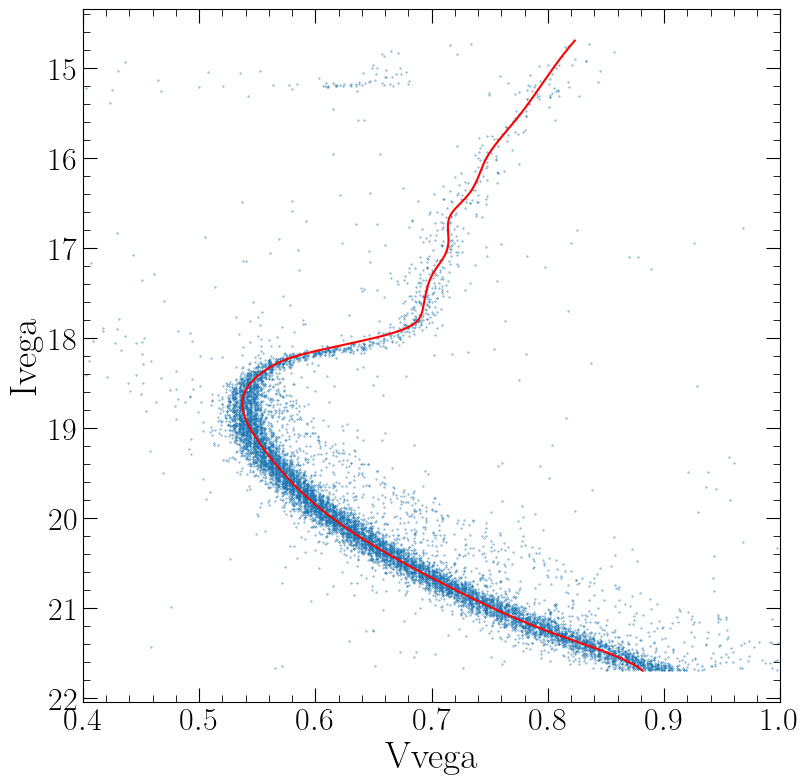

In [22]:
plt.scatter(df_first_cut['Vvega'] - df_first_cut['Ivega'],df_first_cut['Vvega'],s=0.1)
plt.xlabel('Vvega')
plt.ylabel('Ivega')
plt.plot(vp - ip,vp,c='r')
plt.xlim(0.4,1)
#plt.ylim(16,19)
plt.gca().invert_yaxis();

In [23]:
Vvega = df_first_cut['Vvega'].values
Ivega = df_first_cut['Ivega'].values
VIvega = df_first_cut['VIvega'].values
d = []
mag_cut =0.08
ff_v = CubicSpline(ip,vp,extrapolate=True)
ff_i = CubicSpline(vp,ip,extrapolate=True)
Vvega_needed = ff_v(Ivega)
Ivega_needed = ff_i(Vvega)
mask = (((Vvega_needed + mag_cut) > Vvega) & (Vvega > (Vvega_needed - mag_cut)) & ((Ivega_needed + mag_cut) > Ivega) & (Ivega > (Ivega_needed - mag_cut)))
# for i in range(len(Ivega)):
#     Vvega_needed = ff_v(Ivega[i]) #new linear interpolation
#     Ivega_needed = ff_i(Vvega[i])
#     #use slightly bigger cut to avoid deleting too much points. A finer cut will be applied once the fiducial cmd is generated
#     if (((Vvega_needed + mag_cut) > Vvega[i]) & (Vvega[i] > (Vvega_needed - mag_cut)) & ((Ivega_needed + mag_cut) > Ivega[i]) & (Ivega[i] > (Ivega_needed - mag_cut))):
#         d.append(df_first_cut.iloc[i][['Vvega','err','Ivega','err.2','VIvega','err.1','x','y']].values.tolist())
# df_second_cut = pd.DataFrame(d,columns=['v','v_err','i','i_err','vi','vi_err','x','y'])
df_second_cut = df_first_cut[mask]
d = {'v':df_second_cut['Vvega'].values,'v_err':df_second_cut['err'].values,'i':df_second_cut['Ivega'].values,'i_err':df_second_cut['err.2'].values,'vi':df_second_cut['VIvega'].values,'vi_err':df_second_cut['err.1'].values,'x':df_second_cut['x'].values,'y':df_second_cut['y'].values}
df_second_cut = pd.DataFrame(d)

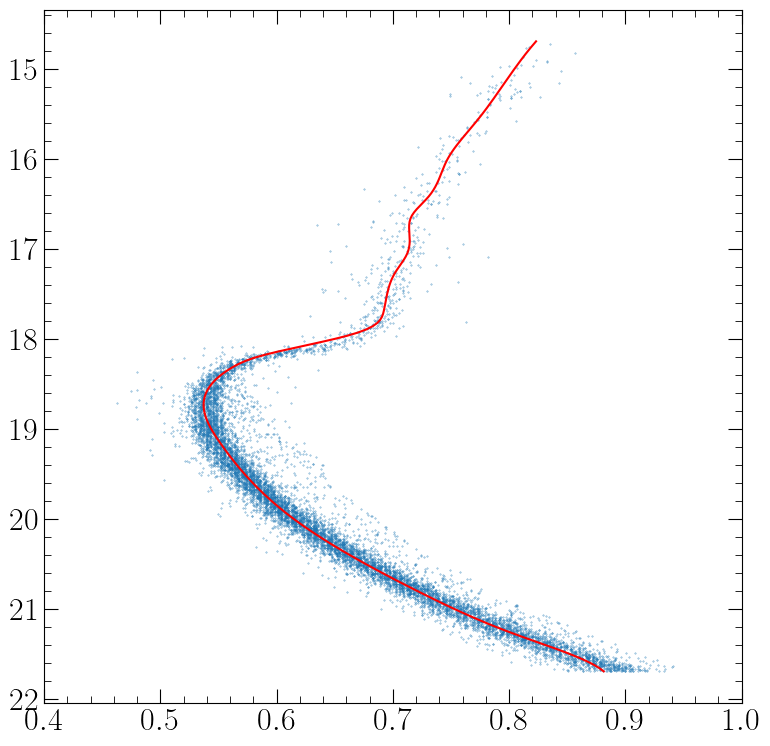

In [24]:
plt.scatter(df_second_cut['vi'],df_second_cut['v'],s=0.1,alpha=0.8)
plt.plot(vp - ip,vp,c='r')
plt.xlim(0.4,1)
#plt.ylim(16,19)
plt.gca().invert_yaxis();

In [25]:
df_second_cut.to_csv("{}/{}_fitstars.dat".format(path,GC_name),sep=',')

In [26]:
print("V_max is: {}".format(max(df_second_cut['v'].values) ))
print("V_min is: {}".format(min(df_second_cut['v'].values) ))
print("I_max is: {}".format(max(df_second_cut['i'].values) ))
print("I_min is: {}".format(min(df_second_cut['i'].values) ))
print("VI_max is: {}".format(max(df_second_cut['vi'].values)))
print("VI_min is: {}".format(min(df_second_cut['vi'].values)))

V_max is: 21.689
V_min is: 14.725
I_max is: 20.837
I_min is: 13.89
VI_max is: 0.941
VI_min is: 0.463


In [27]:
#plot the v vs i image within 3.5 mag from sgb
V_min = V_SGB - 2
V_max = V_SGB + 2
df_third_cut = df_second_cut[(df_second_cut['v'] < V_max) & (df_second_cut['v'] > V_min)]

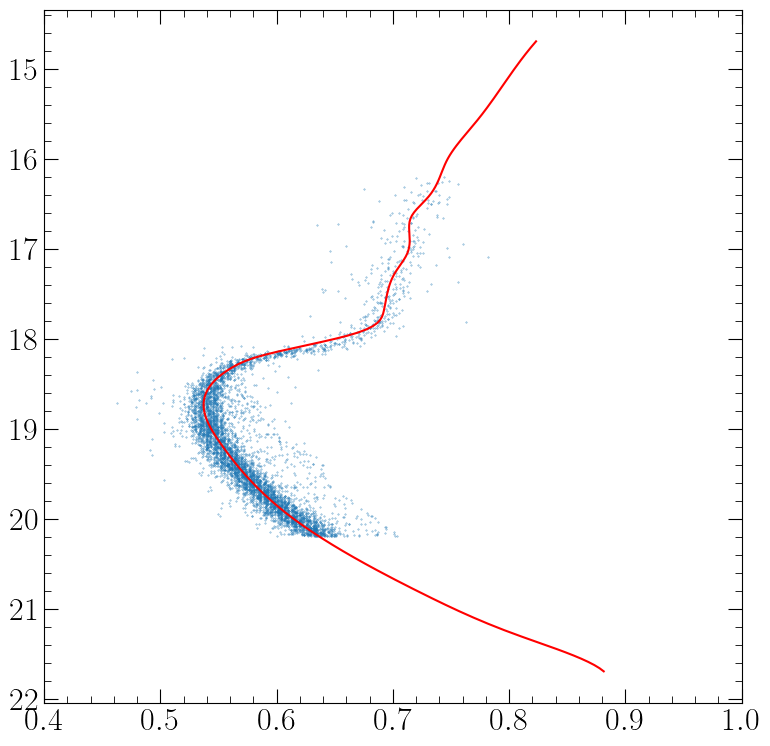

In [28]:
plt.scatter(df_third_cut['vi'],df_third_cut['v'],s=0.1,alpha=0.8)
plt.plot(vp - ip,vp,c='r')
plt.xlim(0.4,1)
#plt.ylim(16,19)
plt.gca().invert_yaxis();

In [29]:
df_third_cut.to_csv("{}/{}_fitstars_2dKS.dat".format(path,GC_name),sep=',')